In [20]:
import xarray as xr
import xesmf as xe
import pandas as pd
import os
import glob
import geopandas as gpd
from distributed import Client
import matplotlib.pyplot as plt

In [21]:
os.chdir('/Users/caramelo/Documents/00_HQ/01_Prevision_Demande/scribe_download/gem/RDPS/GRIBS/')
grib_list_total=sorted(glob.glob('*WDIR*.grib2'))
#grib_list=grib_list_total[0:7]
#grib_list

In [22]:
grib_list_total

['CMC_reg_WDIR_TGL_10_ps10km_2021042300_P054.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P058.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P059.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P060.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P061.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P062.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P063.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P064.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P065.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P067.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P068.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042300_P069.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P051.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P054.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P060.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P061.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P062.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P063.grib2',
 'CMC_reg_WDIR_TGL_10_ps10km_2021042306_P064.g

In [23]:
ds=xr.open_mfdataset(grib_list_total,concat_dim='valid_time',engine='cfgrib',combine='nested',parallel=True)

In [24]:
ds.data_vars

Data variables:
    wdir10   (valid_time, y, x) float32 dask.array<chunksize=(1, 824, 935), meta=np.ndarray>

In [25]:
ds

<xarray.Dataset>
Dimensions:            (valid_time: 39, x: 935, y: 824)
Coordinates:
    time               (valid_time) datetime64[ns] 2021-04-23 ... 2021-04-23T...
    step               (valid_time) timedelta64[ns] 2 days 06:00:00 ... 3 day...
    heightAboveGround  int64 10
    latitude           (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2021-04-25T06:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    wdir10             (valid_time, y, x) float32 dask.array<chunksize=(1, 824, 935), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-04-23T08:28:35 GRIB to CDM+CF via cfgrib-0....

In [26]:
ds.wdir10.attrs

{'GRIB_paramId': 260260,
 'GRIB_shortName': '10wdir',
 'GRIB_units': 'Degree true',
 'GRIB_name': '10 metre wind direction',
 'GRIB_cfVarName': 'wdir10',
 'GRIB_dataType': 'af',
 'GRIB_missingValue': 9999,
 'GRIB_numberOfPoints': 770440,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_NV': 0,
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'polar_stereographic',
 'GRIB_gridDefinitionDescription': 'Polar stereographic ',
 'long_name': '10 metre wind direction',
 'units': 'Degree true'}

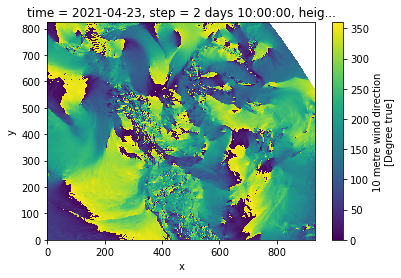

In [27]:
ds.wdir10.isel(valid_time=1).plot()

In [28]:
wdir10=ds.wdir10

/Users/caramelo/anaconda3/envs/test_xesmf/lib/python3.9/site-packages/xesmf/util.py:94: UserWarning: 360 cannot be divided by d_lon = 0.1, might not cover the globe uniformally
  warnings.warn(
/Users/caramelo/anaconda3/envs/test_xesmf/lib/python3.9/site-packages/xesmf/util.py:100: UserWarning: 180 cannot be divided by d_lat = 0.1, might not cover the globe uniformally
  warnings.warn(
/Users/caramelo/anaconda3/envs/test_xesmf/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


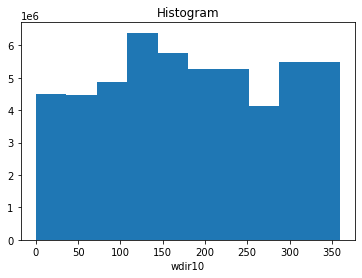

In [29]:
ds = wdir10.rename({'latitude': 'lat', 'longitude': 'lon'})
#ds
ds_out = xe.util.grid_global(0.1, 0.1)
#ds_out  # contains lat/lon values of cell centers and boundaries.
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder
dr_out = regridder(ds)
dr_out.where(dr_out>0).plot()
dr_out['lat'] = dr_out.lat[:,0].drop('lon')
dr_out['lon'] = dr_out.lon[0,:].drop('lat')
dr_out = dr_out.sortby(['x','y'])
dr_out = dr_out.rename({'x':'longitude',
                        'y':'latitude',
                        'lon':'longitude',
                        'lat':'latitude'})
dr_out = dr_out.where(dr_out>0) # remplacer 0 par nan

In [30]:
dr_out

<xarray.DataArray 'wdir10' (valid_time: 39, latitude: 1800, longitude: 3600)>
dask.array<where, shape=(39, 1800, 3600), dtype=float64, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
    time               (valid_time) datetime64[ns] 2021-04-23 ... 2021-04-23T...
    step               (valid_time) timedelta64[ns] 2 days 06:00:00 ... 3 day...
    heightAboveGround  int64 10
  * valid_time         (valid_time) datetime64[ns] 2021-04-25T06:00:00 ... 20...
  * longitude          (longitude) float64 -179.9 -179.9 -179.8 ... 179.8 179.9
  * latitude           (latitude) float64 -89.95 -89.85 -89.75 ... 89.85 89.95
Attributes:
    regrid_method:  bilinear

In [31]:
os.chdir('/Users/caramelo/Documents/GitHub/cmc/')


coords_stations=pd.read_csv('Stations matrice scribe.csv')
coords_stations

,OACI,NOMSTN,LAT,LON
0,CYUL,MONTREAL (DORVAL),45.4667,-73.7500
1,CYOW,OTTAWA,45.3167,-75.6667
2,CYVO,VAL D'OR,48.0500,-77.7833
3,CYSC,SHERBROOKE,45.4333,-71.6833
4,CYQB,QUEBEC,46.8000,-71.4000
5,CYRJ,ROBERVAL,48.5167,-72.2667
6,CYGL,LA GRANDE RIVIERE,53.6333,-77.7000
7,CYBC,BAIE COMEAU,49.1333,-68.2000
8,CYZV,SEPT-ILES,50.2167,-66.2500
9,CYRQ,TROIS-RIVIÈRES (A),46.3539,-72.6792


In [32]:
type(coords_stations)

pandas.core.frame.DataFrame

In [33]:
result = [print(x, y, z, g) for x, y, z, g in zip(coords_stations['LAT'], coords_stations['LON'],coords_stations['NOMSTN'],coords_stations['OACI'])]


45.4667 -73.75 MONTREAL (DORVAL) CYUL
45.3167 -75.6667 OTTAWA CYOW
48.05 -77.7833 VAL D'OR CYVO
45.4333 -71.6833 SHERBROOKE CYSC
46.8 -71.4 QUEBEC CYQB
48.5167 -72.2667 ROBERVAL CYRJ
53.6333 -77.7 LA GRANDE RIVIERE CYGL
49.1333 -68.2 BAIE COMEAU CYBC
50.2167 -66.25 SEPT-ILES CYZV
46.3539 -72.6792 TROIS-RIVIÈRES (A) CYRQ
45.6833 -74.0333 MIRABEL CYMX
47.9167 -74.6167 PARENT CWPK
48.6167 -68.2167 MONT JOLI CYYY
52.9333 -66.8667 WABUSH LAKE CYWK
53.75 -73.6667 LA GRANDE IV CYAH
46.3667 -79.4167 NORTH BAY CYYB
48.7833 -64.4833 GASPE CYGP


In [40]:
def my_function(lat, lon, nomstn, oaci):    
    si101d = dr_out.sel(latitude=lat, longitude=lon,method='nearest')
    df = si101d.reset_coords(drop=True).to_dataframe()
    #df=df.rename(columns={"wdir10": nomstn+'_'+oaci})
    df['station'] = oaci
    return df

In [41]:

result = [my_function(x, y, nomstn, oaci) for x, y, nomstn, oaci in zip(coords_stations['LAT'], coords_stations['LON'],coords_stations['NOMSTN'],coords_stations['OACI'])]
df = pd.concat(result,axis=1).sort_values('valid_time')


In [46]:
type(result)

list

In [47]:
result

[                         wdir10 station
 valid_time                             
 2021-04-25 06:00:00  170.278492    CYUL
 2021-04-25 10:00:00   68.755977    CYUL
 2021-04-25 11:00:00   72.089419    CYUL
 2021-04-25 12:00:00  307.454891    CYUL
 2021-04-25 13:00:00  185.668537    CYUL
 2021-04-25 14:00:00  192.595847    CYUL
 2021-04-25 15:00:00  220.358871    CYUL
 2021-04-25 16:00:00  210.979161    CYUL
 2021-04-25 17:00:00  217.298938    CYUL
 2021-04-25 19:00:00  203.564386    CYUL
 2021-04-25 20:00:00  203.404528    CYUL
 2021-04-25 21:00:00  212.888699    CYUL
 2021-04-25 09:00:00  120.999387    CYUL
 2021-04-25 12:00:00  117.784107    CYUL
 2021-04-25 18:00:00  233.641766    CYUL
 2021-04-25 19:00:00  238.701864    CYUL
 2021-04-25 20:00:00  242.356825    CYUL
 2021-04-25 21:00:00  254.383543    CYUL
 2021-04-25 22:00:00  278.671570    CYUL
 2021-04-25 23:00:00  294.648266    CYUL
 2021-04-26 00:00:00  318.412147    CYUL
 2021-04-26 01:00:00  319.011517    CYUL
 2021-04-26 02:0

In [51]:
df = pd.concat(result,axis=0).sort_values('valid_time')
df

,wdir10,station
valid_time,,
2021-04-25 06:00:00,170.278492,CYUL
2021-04-25 06:00:00,292.674175,CYWK
2021-04-25 06:00:00,248.525846,CYQB
2021-04-25 06:00:00,60.866586,CYRQ
2021-04-25 06:00:00,5.698252,CYGL
...,...,...
2021-04-26 18:00:00,106.505365,CYYB
2021-04-26 18:00:00,221.990151,CYGL
2021-04-26 18:00:00,344.394112,CYRQ


In [64]:
df = pd.concat(result,axis=0).sort_values('station')
df

,wdir10,station
valid_time,,
2021-04-25 06:00:00,104.090620,CWPK
2021-04-25 19:00:00,310.545425,CWPK
2021-04-25 18:00:00,242.625440,CWPK
2021-04-25 12:00:00,164.169902,CWPK
2021-04-25 09:00:00,140.676562,CWPK
...,...,...
2021-04-25 18:00:00,176.756907,CYZV
2021-04-25 19:00:00,140.914432,CYZV
2021-04-25 20:00:00,138.922878,CYZV


In [65]:
df.to_csv("test_wdir10.csv")

## Il faut merge les chacun des variables

In [66]:
df=df.reset_index()
#df.reindex(['valid_time','station'])
df

,valid_time,wdir10,station
0,2021-04-25 06:00:00,104.090620,CWPK
1,2021-04-25 19:00:00,310.545425,CWPK
2,2021-04-25 18:00:00,242.625440,CWPK
3,2021-04-25 12:00:00,164.169902,CWPK
4,2021-04-25 09:00:00,140.676562,CWPK
...,...,...,...
658,2021-04-25 18:00:00,176.756907,CYZV
659,2021-04-25 19:00:00,140.914432,CYZV
660,2021-04-25 20:00:00,138.922878,CYZV
661,2021-04-25 19:00:00,99.437735,CYZV


In [68]:

df_f=df.set_index(['valid_time','station'])

In [77]:
df_f

,,wdir10
valid_time,station,
2021-04-25 06:00:00,CWPK,104.090620
2021-04-25 19:00:00,CWPK,310.545425
2021-04-25 18:00:00,CWPK,242.625440
2021-04-25 12:00:00,CWPK,164.169902
2021-04-25 09:00:00,CWPK,140.676562
...,...,...
2021-04-25 18:00:00,CYZV,176.756907
2021-04-25 19:00:00,CYZV,140.914432
2021-04-25 20:00:00,CYZV,138.922878


In [78]:
df3 = pd.merge(df_f, df_f, on=['valid_time','station'])

In [79]:
df3


wdir10_x    wdir10_y
valid_time          station                        
2021-04-25 06:00:00 CWPK     104.090620  104.090620
2021-04-25 19:00:00 CWPK     310.545425  310.545425
                    CWPK     310.545425  230.114684
                    CWPK     230.114684  310.545425
                    CWPK     230.114684  230.114684
...                                 ...         ...
                    CYZV     140.914432  140.914432
                    CYZV     140.914432   99.437735
                    CYZV      99.437735  140.914432
                    CYZV      99.437735   99.437735
2021-04-25 23:00:00 CYZV      88.817128   88.817128

[799 rows x 2 columns]

In [80]:
df3.to_csv('merge_df.csv')